In [1]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric.utils as pyg_utils
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, MessagePassing

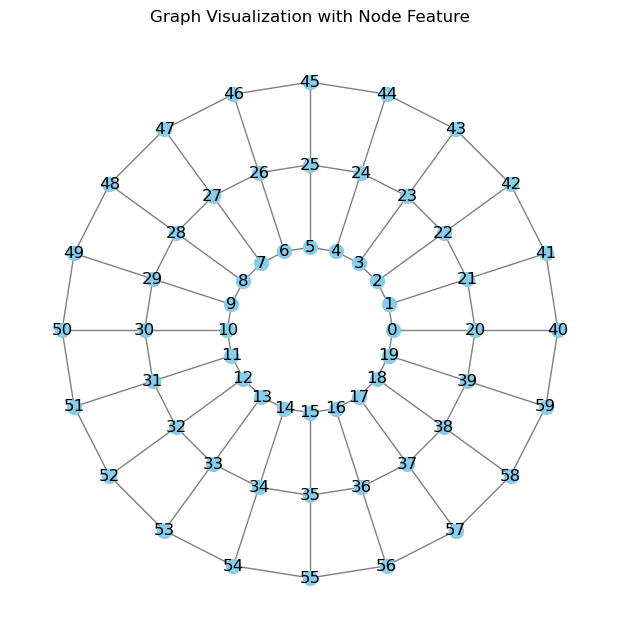

In [2]:
# Function to generate a concentric graph
def generate_concentric_graphs(layers, nodes_per_layer, k):
    G = nx.Graph()

    # Create nodes for each layer
    total_nodes = layers * nodes_per_layer
    for layer in range(layers):
        # Define the radius of the current layer
        radius = layer + 1
        # Calculate the angle between each point (in radians)
        angle_gap = 2 * np.pi / nodes_per_layer

        for i in range(nodes_per_layer):
            angle = i * angle_gap
            x, y = radius * np.cos(angle), radius * np.sin(angle)
            node_id = layer * nodes_per_layer + i
            G.add_node(node_id, pos=(x, y))

            # Connect each node to its k-hop neighbors in the same layer
            for hop in range(1, k + 1):
                neighbor_index = (i + hop) % nodes_per_layer
                G.add_edge(node_id, layer * nodes_per_layer + neighbor_index)
                neighbor_index = (i - hop) % nodes_per_layer
                G.add_edge(node_id, layer * nodes_per_layer + neighbor_index)

    # Connect nodes between layers
    for layer in range(1, layers):
        for i in range(nodes_per_layer):
            this_layer_node = layer * nodes_per_layer + i
            inner_layer_node = (layer - 1) * nodes_per_layer + i
            G.add_edge(this_layer_node, inner_layer_node)

    # Get positions for visualization
    pos = nx.get_node_attributes(G, 'pos')
    return G, pos

# Paramaters for k_model graph
layers = 3
nodes_per_layer = 20
k_model = 1

# Generate the graph
G, pos = generate_concentric_graphs(layers, nodes_per_layer, k_model)

# Convert networkx graph to PyTorch Geometric Data
data = pyg_utils.from_networkx(G)

# Plot the graph
plt.figure(figsize=(6, 6))
nx.draw(G, pos, with_labels=True, node_size=100, node_color="skyblue", edge_color="gray")
plt.title("Graph Visualization with Node Feature")
plt.show()

In [3]:
# Function to generate node features for each node in the graph G
def generate_node_features(G, layers, nodes_per_layer):
    num_nodes = G.number_of_nodes()
    features = torch.zeros(num_nodes, 2)  # Two features: layer of node, node degree

    for node in G.nodes():
        layer = (node // nodes_per_layer) + 1  # Determine the layer of the node (inner circle is layer 1)
        degree = G.degree[node]  # Get the degree of the node
        features[node, 0] = layer
        features[node, 1] = degree

    return features

# Generate node features for the graph G
node_features = generate_node_features(G, layers, nodes_per_layer)

# Print the features of the first 5 nodes
node_features[:5]

# Add node features to PyTorch Geometric Data
data.x = node_features.clone().detach()

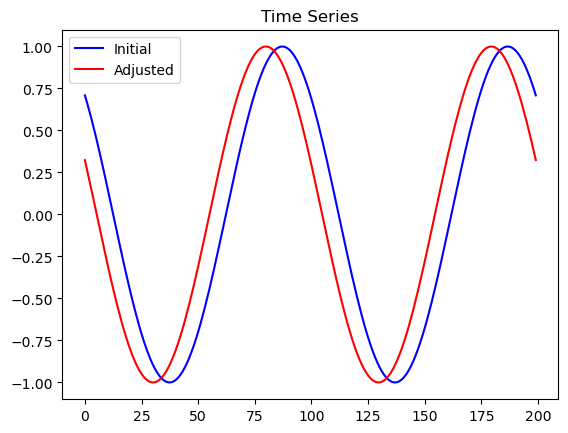

In [4]:
# Parameters for the time series
frequency = 1
time_steps = 200
influence_strength = 0.5

def generate_initial_time_series(num_nodes, frequency, time_steps):
    np.random.seed(42)
    initial_time_series = np.zeros((num_nodes, time_steps))

    for i in range(num_nodes):
        random_start = np.random.rand() * 2 * np.pi  # Generate a random starting point
        t = np.linspace(random_start, random_start + 4 * np.pi, time_steps)
        initial_time_series[i, :] = np.sin(frequency * t)

    return initial_time_series

# Function to adjust the time series based on k-hop neighbors
def adjust_time_series_for_neighbors(G, time_series, influence_strength):
    adjusted_time_series = time_series.copy()
    for node in G.nodes():
        neighbors = list(nx.single_source_shortest_path_length(G, node, cutoff=1).keys())
        neighbors.remove(node)  # exclude the node itself
        for neighbor in neighbors:
            adjusted_time_series[node] += influence_strength * time_series[neighbor]
    
    return adjusted_time_series

# Function to normalize the adjusted time series
def normalize_time_series(time_series):
    num_nodes = time_series.shape[0] 
    normalized_time_series = np.zeros(time_series.shape)
    
    for i in range(num_nodes):
        # Calculate the min and max across all nodes and time steps
        min_val = np.min(time_series[i])
        max_val = np.max(time_series[i])
    
        # Normalize the time series to the range [-1, 1]
        normalized_time_series[i] = 2 * ((time_series[i] - min_val) / (max_val - min_val)) - 1
    
    return normalized_time_series

# Generate initial time series
initial_time_series = generate_initial_time_series(G.number_of_nodes(), frequency, time_steps)

# Generate k_data graph and adjust the time series based on the k-hop neighbors (k_data)
k_data = 2
G_data, pos_data = generate_concentric_graphs(layers, nodes_per_layer, k_data)

adjusted_time_series = adjust_time_series_for_neighbors(G_data, initial_time_series, influence_strength)
normalized_adjusted_time_series = normalize_time_series(adjusted_time_series)

# Add time series to Data
data.y = torch.tensor(normalized_adjusted_time_series[:, 0:100], dtype=torch.float)

plt.plot(initial_time_series[0], 'b', label = 'Initial')
plt.plot(normalized_adjusted_time_series[0], 'r', label = 'Adjusted')
plt.title("Time Series")
plt.legend()

In [18]:
class GNNModel(MessagePassing):
    def __init__(self, in_channels, hidden_channels, out_channel, k_data):
        super(GNNModel, self).__init__(aggr='add')
        
        # Initialize the 2 GCNConv layers
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        
        # Linear layer for forecasting the next time step value
        self.linear = nn.Linear(hidden_channels, out_channel)
        
    def forward(self, data, t):
        y, edge_index = data.y, data.edge_index 

        # Use the last two time step value from y
        last_two_time_step_values = y[:, t:t+2]
        
        # Pass through the 2 GCNConv layers with a non-linear layer after each linear layer
        # Used tanh as its range is from -1 to 1 which is the same as range of sin function
        x = torch.tanh(self.conv1(last_two_time_step_values, edge_index))
        x = torch.tanh(self.conv2(x, edge_index))
        
        # Forecast the next time step value and normalize output to [-1, 1]
        x = torch.tanh(self.linear(x))

        return x
    
# Parameters for the GNN Model
num_node_features = data.num_node_features
hidden_channels = 20
out_channel = 1

# Generate the models and predictions
model = GNNModel(num_node_features, hidden_channels, out_channel, k_data)
#predicted_next_values = model(data)
#print(predicted_next_values)

In [6]:
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop with teacher forcing
model.train()
node_loss = np.zeros(data.num_nodes)
    
for i in range(98):
    optimizer.zero_grad()
        
    # Forward pass
    output = model(data, i)
        
    # Calculate loss
    target = data.y[:, i+2] # The first 2 values are given
    loss = criterion(output.squeeze(), target)
    
    for node in range(data.num_nodes):
        node_loss[node] += criterion(output[node].squeeze(), data.y[node, i+2])
        
    # Backward pass and optimization
    loss.backward()
    optimizer.step()
               
# Print the average loss for the epoch
for node in range(data.num_nodes):
    print(f'Node: {node}, Loss: {node_loss[node] / 98}')

Node: 0, Loss: 0.2637763120690171
Node: 1, Loss: 0.6029329105299346
Node: 2, Loss: 0.5555220623405612
Node: 3, Loss: 0.5712274045360332
Node: 4, Loss: 0.2441570710162727
Node: 5, Loss: 0.3462167467389788
Node: 6, Loss: 0.3375074814776985
Node: 7, Loss: 0.25668615224410074
Node: 8, Loss: 0.2501891194557657
Node: 9, Loss: 0.15214090931172275
Node: 10, Loss: 0.17303301363575216
Node: 11, Loss: 0.1392187585636061
Node: 12, Loss: 0.15333467600296954
Node: 13, Loss: 0.2353642327444894
Node: 14, Loss: 0.27748329785405373
Node: 15, Loss: 0.29029143586450695
Node: 16, Loss: 0.2547674762959383
Node: 17, Loss: 0.18111908192537268
Node: 18, Loss: 0.2148431855805066
Node: 19, Loss: 0.16920111130694954
Node: 20, Loss: 0.3215765855750259
Node: 21, Loss: 0.2070820866798868
Node: 22, Loss: 0.16646511700688577
Node: 23, Loss: 0.31286280495779856
Node: 24, Loss: 0.21555213538967832
Node: 25, Loss: 0.4643352274992028
Node: 26, Loss: 0.29049507452517137
Node: 27, Loss: 0.37241869556660556
Node: 28, Loss: 0

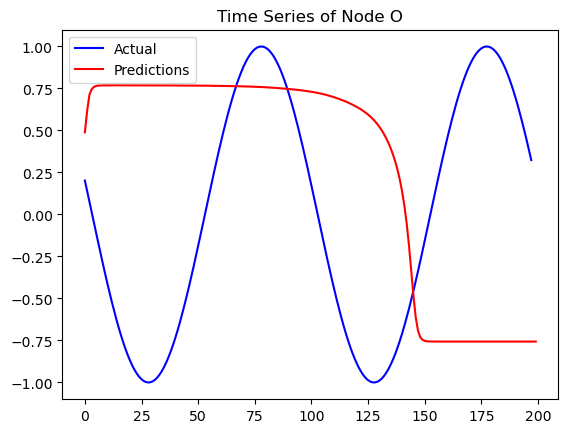

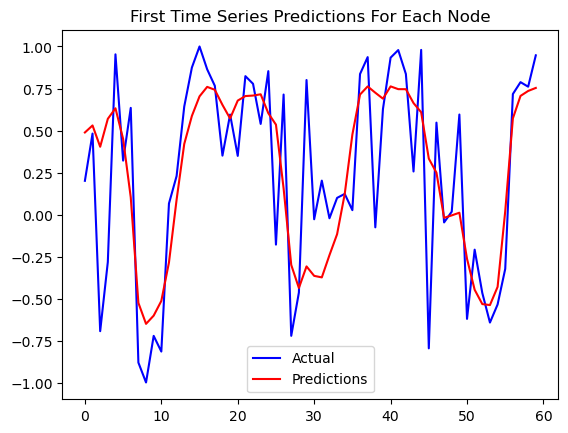

In [7]:
def predictions(model, data, num_time_steps):
    # Initialize the predictions tensor
    num_nodes = data.num_nodes
    predictions = torch.zeros((num_nodes, num_time_steps), dtype=torch.float)

    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for t in range(num_time_steps):
            # Predict the next time step value
            predicted_next_values = model(data, t)

            # Store the predictions
            predictions[:, t] = predicted_next_values.squeeze()

            # Prepare the features for the next time step
            if t < num_time_steps - 1:
                data.y = torch.cat((data.y, predicted_next_values), dim=1)
            
    return predictions

# Perform the auto-regressive prediction (Starting with First 2 Time Steps)
data_prediction = data.clone()
data_prediction.y = torch.tensor(normalized_adjusted_time_series[:, 0:2], dtype=torch.float)
predictions = predictions(model, data_prediction, time_steps)

plt.plot(normalized_adjusted_time_series[0, 2:], 'b', label = 'Actual')
plt.plot(predictions[0, :], 'r', label = 'Predictions')
plt.title("Time Series of Node O")
plt.legend()

plt.figure()
plt.plot(normalized_adjusted_time_series[:, 2], 'b', label = 'Actual')
plt.plot(predictions[:, 0], 'r', label = 'Predictions')
plt.title("First Time Series Predictions For Each Node")
plt.legend()